In [1]:
from typing import Tuple
from abc import abstractmethod
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from bandits import Bandit, BinaryBandit, ContinuousBandit

In [3]:
class LearningRule(object):
    
    def __init__(self, num_arms, horizon):
        self.num_arms = num_arms
        self.horizon = horizon
        self.history = {}
        self.reset()
            
    def reset(self) -> None:
        '''Forget the past experiences'''
        for i in range(self.num_arms):
            self.history[i] = []
    
    @abstractmethod
    def act(self) -> int:
        '''Determine which arm to pull next'''
    
    def update(self, action, reward) -> None:
        '''Save an action / reward pair'''
        if action < 0 or action >= self.num_arms:
            raise ValueError("action must be be in the range [0, num_arms)")
        self.history[action].append(reward)
        
class RandomLearningRule(LearningRule):
    
    def __init__(self, num_arms, horizon):
        super(RandomLearningRule, self).__init__(num_arms, horizon)
        self.rng = np.random.default_rng()
    
    def act(self) -> int:
        return int(np.floor(self.num_arms * self.rng.random()))
    
class ExploreCommitLearningRule(LearningRule):
    
    def __init__(self, num_arms, horizon):
        super(ExploreCommitLearningRule, self).__init__(num_arms, horizon)
    
    def act(self) -> int:
        num_points = 0
        for a in range(self.num_arms):
            num_points += len(self.history[a])
        if num_points < self.horizon / 5:
            return num_points % self.num_arms
        else:
            avg_return = np.zeros(self.num_arms)
            for a in range(self.num_arms):
                avg_return[a] = np.mean(self.history[a])
            return np.argmax(avg_return)
        

In [4]:
def evaluateLearningRule(learning_rule: LearningRule,
                         bandit: Bandit,
                         horizon: int = 200,
                         num_eval: int = 200) -> Tuple[np.ndarray, np.ndarray]:
    '''Evaluate the performance of a learning rule on a class of bandits'''
    rng = np.random.default_rng(397428)
    regrets = np.zeros((num_eval, horizon))
    for i in range(num_eval):
        # seed the bandit and reset it (now arms are different)
        bandit.seed(rng.integers(0,high=2e8))
        bandit.reset()
        learning_rule.reset()
        for j in range(horizon):
            action = learning_rule.act()
            reward = bandit.pull(action)
            regret = bandit.regret(action) # this function is for evaluation only
            learning_rule.update(action, reward)
            regrets[i,j] += regret
    return np.mean(regrets, axis=0), 2 * np.std(regrets, axis=0) / np.sqrt(num_eval)
            

In [17]:
class YourLearningRule(LearningRule):

    def __init__(self, num_arms, horizon):
        super(YourLearningRule, self).__init__(num_arms, horizon)
    
    def act(self):
        '''
        TODO: write this function, use the history member variable 
        which maps from actions to the rewards collected by this action
        '''
        # epsilon greedy learning rule
        num_points = 0
        
        # start by pulling each arm twice
        for a in range(self.num_arms):
            num_points += len(self.history[a])
        if num_points < 3 * self.num_arms:
            return num_points % self.num_arms
        else:
            avg_return = np.zeros(self.num_arms)
            for a in range(self.num_arms):
                avg_return[a] = np.mean(self.history[a])
            if np.random.random() < 0.95:
                return np.argmax(avg_return)
            else:
                return int(np.floor(self.num_arms * np.random.random()))
        
        


In [38]:
class UCBRule(LearningRule):

    def __init__(self, num_arms, horizon):
        super(UCBRule, self).__init__(num_arms, horizon)
    
    def act(self):
        '''
        TODO: write this function, use the history member variable 
        which maps from actions to the rewards collected by this action
        '''
        # epsilon greedy learning rule
        num_points = 0
        
        # start by pulling each arm once
        for a in range(self.num_arms):
            num_points += len(self.history[a])
        if num_points < self.num_arms:
            return num_points
        
        avg_return = np.zeros(self.num_arms)
        num_return = np.zeros(self.num_arms)
        for a in range(self.num_arms):
            avg_return[a] = np.mean(self.history[a])
            num_return[a] = len(self.history[a])
        #By setting the horizion to something much smaller (so putting 2. in the log) one gets better results
        ucb = avg_return + np.sqrt(2 * np.log(self.horizon ** 2) / num_return)
        return np.argmax(ucb)
        


average random regret =  0.41158632909696424
average explore commit regret =  0.1671814617523767
average epsilon greedy =  0.1634049628984079
average ucb =  0.28389585384618277


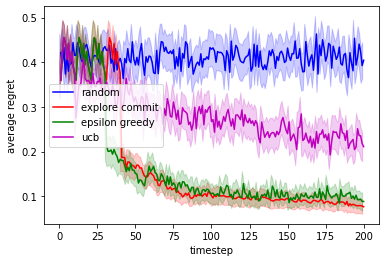

In [40]:
# report regrets and plot everything
regret_mean, regret_std = evaluateLearningRule(RandomLearningRule(10, 200), ContinuousBandit(10))
print('average random regret = ', np.mean(regret_mean))
plt.plot(np.arange(regret_mean.shape[0])+1, regret_mean, color='b', label='random')
plt.fill_between(np.arange(regret_mean.shape[0]), regret_mean - regret_std, regret_mean + regret_std, color='b', alpha=0.2)

regret_mean, regret_std = evaluateLearningRule(ExploreCommitLearningRule(10, 200), ContinuousBandit(10))
print('average explore commit regret = ', np.mean(regret_mean))
plt.plot(np.arange(regret_mean.shape[0])+1, regret_mean, color='r', label='explore commit')
plt.fill_between(np.arange(regret_mean.shape[0]), regret_mean - regret_std, regret_mean + regret_std, color='r', alpha=0.2)

regret_mean, regret_std = evaluateLearningRule(YourLearningRule(10, 200), ContinuousBandit(10))
print('average epsilon greedy = ', np.mean(regret_mean))
plt.plot(np.arange(regret_mean.shape[0])+1, regret_mean, color='g', label='epsilon greedy')
plt.fill_between(np.arange(regret_mean.shape[0]), regret_mean - regret_std, regret_mean + regret_std, color='g', alpha=0.2)


regret_mean, regret_std = evaluateLearningRule(UCBRule(10, 200), ContinuousBandit(10))
print('average ucb = ', np.mean(regret_mean))
plt.plot(np.arange(regret_mean.shape[0])+1, regret_mean, color='m', label='ucb')
plt.fill_between(np.arange(regret_mean.shape[0]), regret_mean - regret_std, regret_mean + regret_std, color='m', alpha=0.2)


plt.legend()
plt.ylabel('average regret')
plt.xlabel('timestep')
plt.show()